## Fraud Modellemesi
### Veri Bilimi Okulu - 23 Ekim 2019


### Bu Notebookta Kaggle'dan aldığımız sentetik bir fraud verisetiyle fraud modellemesi yapacağız.

Veriseti: https://www.kaggle.com/c/home-credit-default-risk
    
    
### Verisetinin Açıklaması

Bu veriseti kaggle'da 1 yıl önce düzenlenen ev kredisi risk tahmini yarışmasında kullanılan bir verisetidir. 

### Verinin Yapısı

![title](img/home_credit.png)


### Neler Yaptık?

Veriyi bu hale getirmek için önce yukarıda işaretlediğimiz 3 verisetini SK_ID_CURR üzerinden merge ettik. Ardından, tekilleştirdik. Ardından değişken değişken bakarak, %20'den fazlası boş olan değişkenleri düşürdük. Son olarakta kategorik değişkenler için, dağılımlarına baktık. Eğer değişkenin içerisinde 1 kategori o değişkenin %80'inden fazlasını kapsıyorsa o değişken düşürüldü.

In [1]:
# Eğer Kütüphaneler yüklü değilse bu hücreyi çalıştırabilirsiniz.
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install scikit-learn
!pip install Boruta

In [64]:
# Kütüphanelerin içeriye alınması
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import matplotlib.pyplot as plt#visualization
%matplotlib inline
import seaborn as sns#visualization
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pickle

In [37]:
# Verisetinin okunması

data = pd.read_csv("modelData.csv")
data.set_index('SK_ID_CURR',inplace=True)
data.head()

,TARGET,NAME_CONTRACT_TYPE_x,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,...,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,XNA,XAP,New,Vehicles,POS,XNA,Stone,500.0,Auto technology,low_normal
100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,Cash through the bank,XAP,Refreshed,Consumer Electronics,POS,XNA,Country-wide,-1.0,Consumer electronics,middle
100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,Cash through the bank,XAP,New,Mobile,POS,XNA,Regional / Local,30.0,Connectivity,middle
100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,XNA,XAP,Repeater,XNA,Cash,XNA,Credit and cash offices,-1.0,XNA,XNA
100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,Cash through the bank,XAP,Repeater,XNA,Cash,x-sell,Country-wide,-1.0,Consumer electronics,high


In [38]:
#Verisetinin Açıklamaları

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 74 columns):
TARGET                          307511 non-null int64
NAME_CONTRACT_TYPE_x            307511 non-null object
CODE_GENDER                     307511 non-null object
FLAG_OWN_CAR                    307511 non-null object
FLAG_OWN_REALTY                 307511 non-null object
CNT_CHILDREN                    307511 non-null int64
AMT_INCOME_TOTAL                307511 non-null float64
AMT_CREDIT_x                    307511 non-null float64
AMT_ANNUITY_x                   307511 non-null float64
AMT_GOODS_PRICE_x               307511 non-null float64
NAME_TYPE_SUITE_x               307511 non-null object
NAME_INCOME_TYPE                307511 non-null object
NAME_EDUCATION_TYPE             307511 non-null object
NAME_FAMILY_STATUS              307511 non-null object
NAME_HOUSING_TYPE               307511 non-null object
REGION_POPULATION_RELATIVE      307511 non-null float64
D

In [39]:
# Hedef Değişken Dağılımının Kontrol Edilmesi

data.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [40]:
# Bu kısımda kategorik ve numerik verileri belirleyip, kategorik verileri,
#modellemeye uygun hale getirmek için numerik hale getiriyoruz.
def KorS(y):
    types = []
    for i in y:
        if type(data[i].values[0]) == str:
            types.append((i,"Categorical"))
        else:
            types.append((i,"Continous"))
    return types

tip =  pd.DataFrame(KorS(data.columns));tip.columns=["features","tip"];tip.set_index("features",inplace=True)
for i in tip[tip.tip == "Categorical"].index:
    data[i] = data[i].astype('category').cat.codes.astype(np.int64)

# Under-Sampling

Verisetimizde **24825 Fraud** ve **282686 Nan-Fraud** Olduğu için modellemeyi daha sağlıklı yapmak adına, Over veya Under Sampling yapmamız gerekiyor. Biz bu çalışmada Random Under Sampling yapacağız. 

![](img/under.png)

In [41]:
print("Data'nın Bölünmeden Önceki Boyutu", len(data))
dataFraud = data[data.TARGET == 1]
dataNonFraud = data[data.TARGET == 0]
data = pd.concat([dataNonFraud.sample(len(dataFraud)*2, random_state=5,replace=True), dataFraud])
print("Data'nın Yeni Boyutu: ", len(data))

Data'nın Bölünmeden Önceki Boyutu 307511
Data'nın Yeni Boyutu:  74475


In [42]:
X = data.iloc[:, data.columns != 'TARGET'].values
y = data.TARGET.values

# Değişken Seçimi

Bu çalışmada değişken seçimi için Boruta adlı algoritma kullanılmıştır. 

### Kaynaklar

- [Boruta – A System for Feature Selection](https://pdfs.semanticscholar.org/85a8/b1d9c52f9f795fda7e12376e751526953f38.pdf)
- [Feature Selection with the Boruta Package](https://www.jstatsoft.org/article/view/v036i11/v36i11.pdf)

In [24]:
rfc = RandomForestClassifier(n_estimators=135, n_jobs=-1, class_weight="balanced")
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=2)
boruta_selector.fit(X,y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	73
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	12 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	13 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	14 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	15 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	16 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	17 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	18 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	19 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	20 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	21 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	22 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	23 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	24 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


Iteration: 	25 / 100
Confirmed: 	13
Tentative: 	1
Rejected: 	59
Iteration: 	26 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	60


BorutaPy finished running.

Iteration: 	27 / 100
Confirmed: 	13
Tentative: 	0
Rejected: 	60


D:\Anaconda\lib\site-packages\boruta\boruta_py.py:418: RuntimeWarning: invalid value encountered in greater
  hits = np.where(cur_imp[0] > imp_sha_max)[0]


BorutaPy(alpha=0.05,
     estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=52, n_jobs=-1, oob_score=False,
            random_state=<mtrand.RandomState object at 0x000001A45DFC6480>,
            verbose=0, warm_start=False),
     max_iter=100, n_estimators='auto', perc=100,
     random_state=<mtrand.RandomState object at 0x000001A45DFC6480>,
     two_step=True, verbose=2)

In [43]:
feature_df = pd.DataFrame(data.drop(['TARGET'], axis=1).columns.tolist(), columns=['features'])
feature_df['rank']=boruta_selector.ranking_
feature_df = feature_df.sort_values('rank', ascending=True).reset_index(drop=True)
print ('\n Top %d features:' % boruta_selector.n_features_)
print (feature_df.head(boruta_selector.n_features_))


 Top 13 features:
                  features  rank
0            DAYS_EMPLOYED     1
1             EXT_SOURCE_3     1
2   DAYS_LAST_PHONE_CHANGE     1
3              DAYS_CREDIT     1
4       DAYS_CREDIT_UPDATE     1
5          DAYS_ID_PUBLISH     1
6        DAYS_REGISTRATION     1
7               DAYS_BIRTH     1
8             EXT_SOURCE_2     1
9             AMT_CREDIT_x     1
10           DAYS_DECISION     1
11       AMT_GOODS_PRICE_x     1
12           AMT_ANNUITY_x     1


In [44]:
pd.DataFrame(feature_df.head(boruta_selector.n_features_).values)[0].values

array(['DAYS_EMPLOYED', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_CREDIT', 'DAYS_CREDIT_UPDATE', 'DAYS_ID_PUBLISH',
       'DAYS_REGISTRATION', 'DAYS_BIRTH', 'EXT_SOURCE_2', 'AMT_CREDIT_x',
       'DAYS_DECISION', 'AMT_GOODS_PRICE_x', 'AMT_ANNUITY_x'],
      dtype=object)

In [93]:
data = data[['EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_CREDIT','EXT_SOURCE_2', 'AMT_CREDIT_x','AMT_ANNUITY_x','TARGET']]

# Not: Seçtikleri üzerinden bazı değişkenleri kaldırdım. 

In [110]:
data.head()

,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,DAYS_CREDIT,EXT_SOURCE_2,AMT_CREDIT_x,AMT_ANNUITY_x,TARGET
SK_ID_CURR,,,,,,,
123614,0.000000,1746.0,0.0,0.315294,630000.0,31500.0,0
125883,0.703203,0.0,2345.0,0.233106,994500.0,32211.0,0
257333,0.191822,1809.0,259.0,0.768554,560664.0,18085.5,0
392683,0.591977,622.0,1564.0,0.557321,225000.0,23755.5,0
272454,0.000000,686.0,0.0,0.336269,180000.0,9000.0,0


Değişken seçimini gerçekleştirdikten sonra modelleme için hazırız. Son olarak değişkenler arası korelasyon katsayısına bakacağız.

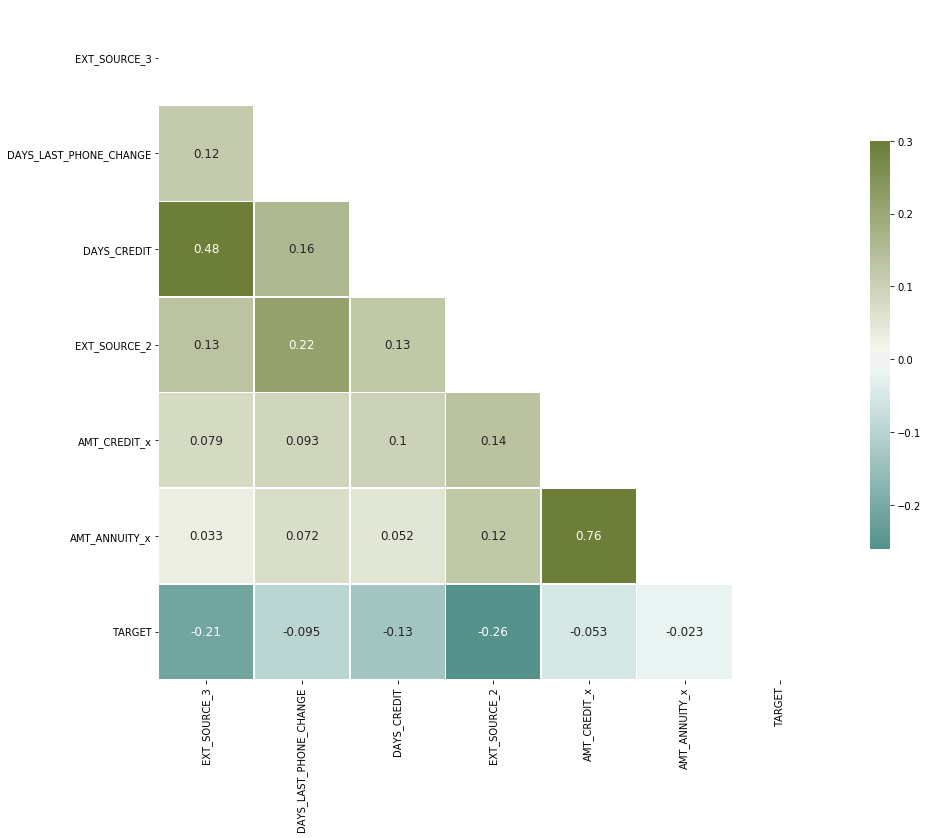

In [111]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(900, 100, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot_kws={'size': 12})
plt.savefig('corr.png')

# Modelleme

Modelleme için Deniz Kılınç'ın yazdığı [Makine Öğrenimi ve Derin Öğrenme ile Müşteri Kayıp (Churn) Analizi-1](https://medium.com/deep-learning-turkiye/makine-%C3%B6%C4%9Frenimi-ve-derin-%C3%B6%C4%9Frenme-ile-m%C3%BC%C5%9Fteri-kay%C4%B1p-churn-analizi-1-63a4513b8a6f) makalesinde kodunu biraz geliştirip elde ettiğimiz bütün modellerin detaylı sonuçlarının ortaya çıkarıldığı bir yapı ile ilk testlerimizi yapacağız. Ardından en iyi modellerden birini seçip, parametre optimizasyonu yaparak son modelimizi elde edeceğiz

In [112]:
X = data.iloc[:, data.columns != 'TARGET']
y = data.TARGET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 25)

In [113]:
#Deniz Kılınç

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Decision Tree (CART)',DecisionTreeClassifier())) 
models.append(('K-NN', KNeighborsClassifier()))
models.append(('AdaBoostClassifier', AdaBoostClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier()))

for name, model in models:
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("-----------------------"+str(name)+"------------------")
    print(classification_report(y_test,y_pred))
    print("Test Score: ",accuracy_score(y_test,y_pred))
    print("Train Score: ",model.score(X_train,y_train))

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


-----------------------Logistic Regression------------------
              precision    recall  f1-score   support

           0       0.67      1.00      0.80     14883
           1       0.00      0.00      0.00      7460

   micro avg       0.67      0.67      0.67     22343
   macro avg       0.33      0.50      0.40     22343
weighted avg       0.44      0.67      0.53     22343

Test Score:  0.6661146667860179
Train Score:  0.6669032456073045
-----------------------Naive Bayes------------------
              precision    recall  f1-score   support

           0       0.69      0.92      0.78     14883
           1       0.49      0.16      0.24      7460

   micro avg       0.66      0.66      0.66     22343
   macro avg       0.59      0.54      0.51     22343
weighted avg       0.62      0.66      0.60     22343

Test Score:  0.6640558564203554
Train Score:  0.6631627407350572
-----------------------Decision Tree (CART)------------------
              precision    recall  f1-sc

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


-----------------------RandomForestClassifier------------------
              precision    recall  f1-score   support

           0       0.72      0.88      0.79     14883
           1       0.58      0.33      0.42      7460

   micro avg       0.70      0.70      0.70     22343
   macro avg       0.65      0.60      0.61     22343
weighted avg       0.68      0.70      0.67     22343

Test Score:  0.6963254710647631
Train Score:  0.9779597943681424


# Son Model

AdaBoostClassifier diğerlerine göre daha iyi çıktığı için onda parametre optimizasyonunu yaptık ve artık modelleme aşaması bitti.

In [114]:
model = AdaBoostClassifier(n_estimators=137, random_state=51)
model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred) 
print(classification_report(y_test,y_pred))
print("Test Score: ",accuracy_score(y_test,y_pred))
print("Train Score: ",model.score(X_train,y_train))

              precision    recall  f1-score   support

           0       0.73      0.90      0.80     14883
           1       0.62      0.33      0.43      7460

   micro avg       0.71      0.71      0.71     22343
   macro avg       0.67      0.62      0.62     22343
weighted avg       0.69      0.71      0.68     22343

Test Score:  0.7089021169941369
Train Score:  0.7126524975063301


# Modeli Saklama

Modeli saklama kısmında, Pickle adlı python kütüphanesinden yararlanacağız. Pickle makine öğrenmesi modellerinin yapısını byte olarak tutmaya yarayan bir python kütüphanesi

In [115]:
filename = 'base-model.sav'
pickle.dump(model, open(filename, 'wb'))

In [117]:
data[data.TARGET == 1].head()

,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,DAYS_CREDIT,EXT_SOURCE_2,AMT_CREDIT_x,AMT_ANNUITY_x,TARGET
SK_ID_CURR,,,,,,,
100002,0.139376,1134.0,1437.0,0.262949,406597.5,24700.5,1
100031,0.190706,161.0,1365.0,0.548477,979992.0,27076.5,1
100047,0.320163,1075.0,2055.0,0.306841,1193580.0,35028.0,1
100049,0.399676,1480.0,2179.0,0.674203,288873.0,16258.5,1
100096,0.720944,0.0,2922.0,0.023952,252000.0,14593.5,1


In [118]:
data[data.TARGET == 0].head()

,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,DAYS_CREDIT,EXT_SOURCE_2,AMT_CREDIT_x,AMT_ANNUITY_x,TARGET
SK_ID_CURR,,,,,,,
123614,0.000000,1746.0,0.0,0.315294,630000.0,31500.0,0
125883,0.703203,0.0,2345.0,0.233106,994500.0,32211.0,0
257333,0.191822,1809.0,259.0,0.768554,560664.0,18085.5,0
392683,0.591977,622.0,1564.0,0.557321,225000.0,23755.5,0
272454,0.000000,686.0,0.0,0.336269,180000.0,9000.0,0
